In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.linear_model import SGDRegressor
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

In [4]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    return np.sum(np.sin(w)**2)

Задание 1. Градиентный спуск для функции f

In [5]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    return np.sin(2*w)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение:

In [6]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

Функция градиентного спуска в минимум для функции f:

In [7]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w)

    return np.vstack(history)

Визуализация точек градиентного спуска на 3D-графике нашей функции:

In [11]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.gca(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

/var/folders/t6/n0vfh9y567x1_8_f3k35m4400000gn/T/ipykernel_4664/1727858522.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


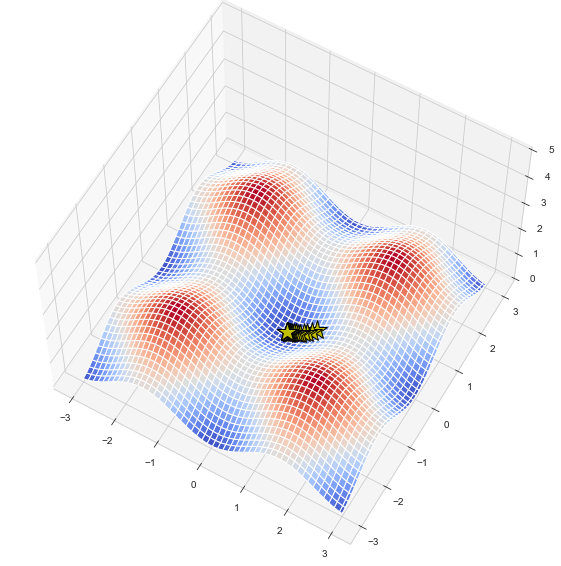

In [12]:
steps = gradient_desc_vis(f, grad_f)

Зависимость значения функции от шага градиентного спуска:

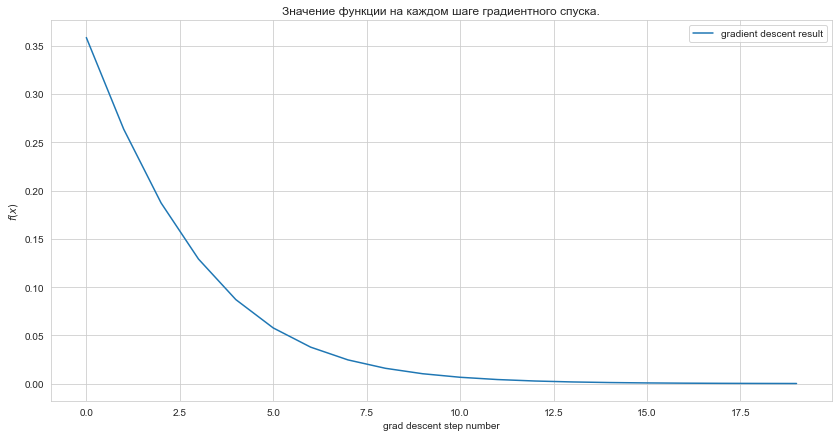

In [13]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге градиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

Задание 2. Реализация линейной регресии

Задание 2.1. MSE и ее градиент 

In [14]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    N = y_true.shape[0]
    
    return 1/N * np.sum((y_true - y_pred)**2)


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    N = y_true.shape[0]
    
    return 2/N * (np.dot(X.T, (y_true - y_pred)))
    

class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

In [ ]:
Класс для расчета градиента функций потерь

In [15]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

In [16]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

Задание 2.2. Предсказания линейной регрессии

In [17]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return np.dot(X_test, self.W)

    
    
    def __repr__(self):
        return "My custom linear regression"

Проверка реализации:

In [18]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

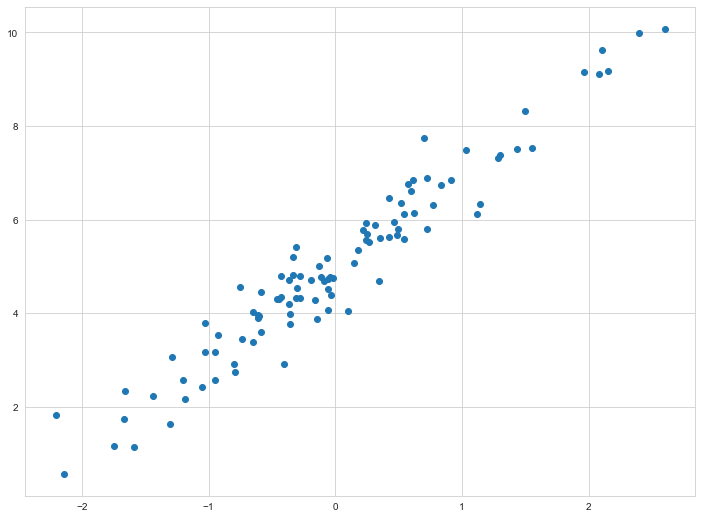

In [19]:
plt.scatter(X, y);

In [21]:
custom_lin_reg = CustomLinearRegression()

In [22]:
custom_lin_reg.fit(X, y)

My custom linear regression

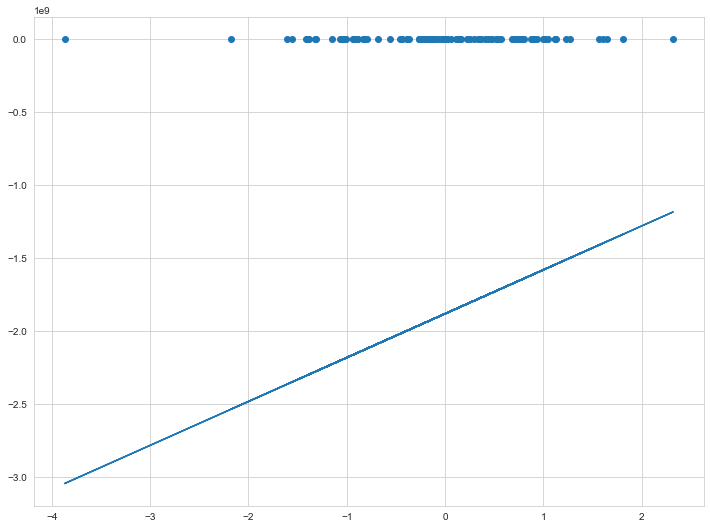

In [124]:
#очень плохо...
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

2.3. Используем встроенную линейную регрессию

In [127]:
data = load_boston()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

In [128]:
#стандартизация
scaler = StandardScaler()
scaler.fit(X)
data_scl = scaler.transform(X)
print(data_scl)

[[-0.41978194  0.28482986 -1.2879095  ... -1.45900038  0.44105193
  -1.0755623 ]
 [-0.41733926 -0.48772236 -0.59338101 ... -0.30309415  0.44105193
  -0.49243937]
 [-0.41734159 -0.48772236 -0.59338101 ... -0.30309415  0.39642699
  -1.2087274 ]
 ...
 [-0.41344658 -0.48772236  0.11573841 ...  1.17646583  0.44105193
  -0.98304761]
 [-0.40776407 -0.48772236  0.11573841 ...  1.17646583  0.4032249
  -0.86530163]
 [-0.41500016 -0.48772236  0.11573841 ...  1.17646583  0.44105193
  -0.66905833]]


In [134]:
linear_regression_model = SGDRegressor(tol=0.001, eta0=0.01) 
linear_regression_model.fit(data_scl, y)
predictions = linear_regression_model.predict(data_scl)
MSE = mean_squared_error(y, predictions)
RMSE = np.sqrt(MSE)
max1 = np.amax(predictions)
min1 = np.amin(predictions)
RMSE_norm = RMSE / (max1 - min1)
print('Mean Squared Error:', MSE)
print('Norm Root Mean Square Error:', RMSE_norm)

Mean Squared Error: 22.033179832119547
Norm Root Mean Square Error: 0.0955064543475545


In [41]:
linear_regression_model.fit(data_scl, y) 
sorted(list(zip(feature_names, linear_regression_model.coef_)),
       key=lambda x: abs(x[1]))

[('AGE', -0.009107145507405084),
 ('INDUS', -0.035212597500855626),
 ('CHAS', 0.6909935716686659),
 ('B', 0.8307391531993816),
 ('CRIM', -0.877661188922971),
 ('ZN', 1.0091220535698089),
 ('TAX', -1.5266624689245327),
 ('NOX', -1.9873149802166996),
 ('PTRATIO', -2.030958539844782),
 ('RAD', 2.189101700927651),
 ('RM', 2.695635101621158),
 ('DIS', -3.086791941010436),
 ('LSTAT', -3.7111560740963885)]

Ниболее важные признаки:
LSTAT: Percentage of lower status of the population; 
RM: Average number of rooms per dwelling; 
DIS: Weighted distances to five Boston employment centers; 
LSTAT: Percentage of lower status of the population

Задание 3. Реализация логистической регресии

Задание 3.1. Реализация сигмоиды

In [45]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1 / (1 + np.exp(-output))

Задание 3.2. BCE Loss и ее градиент

In [46]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    return -np.sum(y_true * np.log(sigmoid(y_pred))+ (1-y_true)* np.log(1-sigmoid(y_pred)))

    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.dot(X.T, (sigmoid(y_pred) - y_true))



class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

Задание 3.3. Предсказания логистической регрессии

In [47]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return (np.exp(np.dot(X_test, self.W)))/(1 + np.exp(np.dot(X_test, self.W)))
    
    
    def __repr__(self):
        return "My custom logistic regression"

Проверка алгоритма:

In [48]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

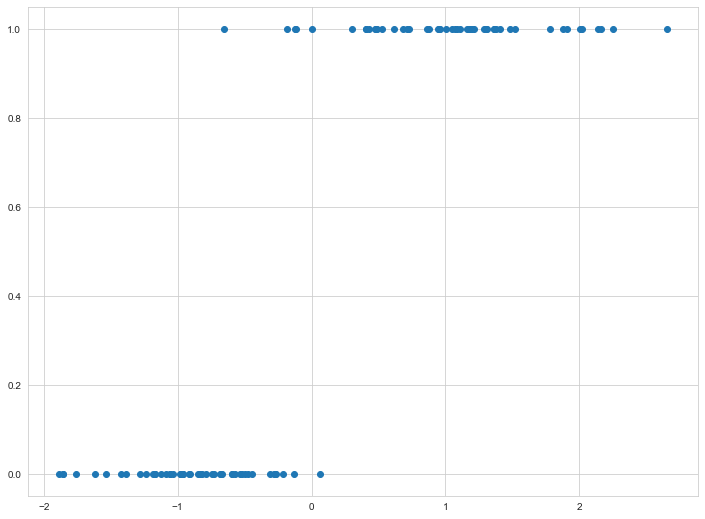

In [49]:
plt.scatter(X, y);

In [50]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

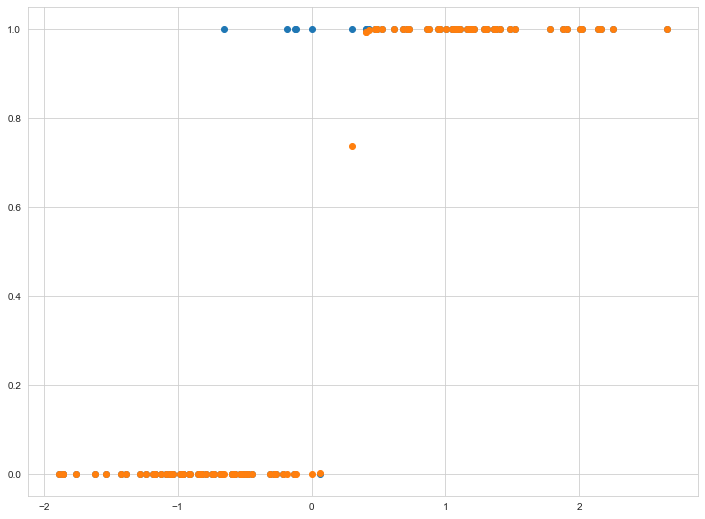

In [51]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Задание 3.4. Применение логистической регрессии 

In [74]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [159]:
pokemon = pd.read_csv("Pokemon.csv")
y = (pokemon["Legendary"].astype(int))
X = pokemon
pokemon.__delitem__('#')
pokemon.__delitem__('Name')
pokemon.__delitem__('Type 1')
pokemon.__delitem__('Type 2')
pokemon.__delitem__('Generation')
pokemon.__delitem__('Legendary')

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print(X)
pokemon.head()

[[-0.97676549 -0.95062622 -0.92490618 ... -0.2391303  -0.24818854
  -0.80150318]
 [-0.25108843 -0.3628221  -0.5241302  ...  0.21955954  0.29115635
  -0.28501525]
 [ 0.74984544  0.42091674  0.09244823 ...  0.83114599  1.01028289
   0.40363531]
 ...
 [ 1.37542912  0.42091674  0.95565803 ...  2.36011211  2.08897269
   0.05931003]
 [ 2.04271837  0.42091674  2.49710411 ...  2.97169856  2.08897269
   0.40363531]
 [ 1.37542912  0.42091674  0.95565803 ...  1.74852566  0.65071962
   0.05931003]]


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,318,45,49,49,65,65,45
1,405,60,62,63,80,80,60
2,525,80,82,83,100,100,80
3,625,80,100,123,122,120,80
4,309,39,52,43,60,50,65


Разделите ваши данные на тестовую и тренировочную выборку:

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, random_state=42)

Обучите модель LogisticRegression из sklearn

In [161]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [162]:
predicts = clf.predict(X_test)
print(predicts)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


Нарисуйте confusion matrix.

In [163]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, clf.predict(X_test))
print(cm)

[[243   5]
 [  6  10]]


In [149]:
cmd_obj = ConfusionMatrixDisplay(cm)

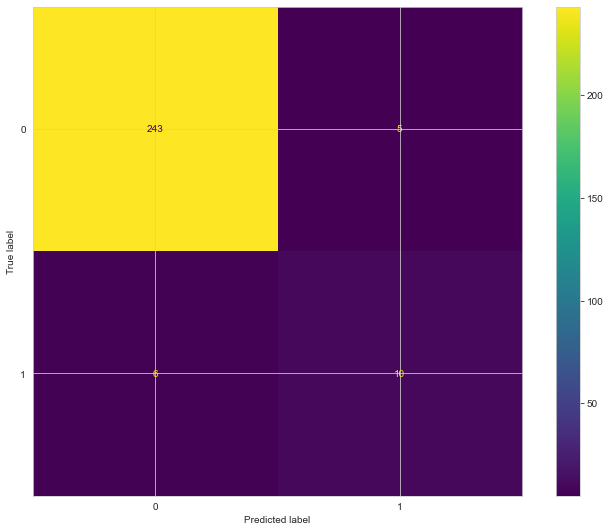

In [150]:
cmd_obj.plot()

Изобразите ROC кривую и посчитайте площадь под ней.

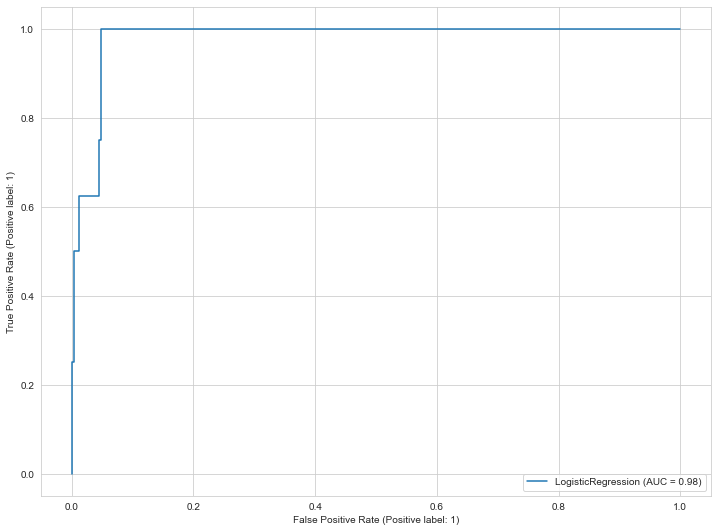

In [165]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import datasets, metrics, model_selection, svm

metrics.plot_roc_curve(clf, X_test, y_test) 
plt.show()

In [166]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y, clf.decision_function(X))

0.9745996860282575

Задание 4. Расскажите о вашей любимой музыкальной группе:

Metronomy.
Мое отношение к ней может описать факт - в спотифае вхожу в 0.5% самых преданных слушателей, не могу остановиться уже больше 10 лет, все жду когда надоест...

несколько треков:
Corinne
Love letters
Old sckool
Night owl



